In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import torch
import bvcopula
import marginal as mg
from vine import CVine
from scipy.stats import norm
import MI

In [11]:
NSamp=10000
device = torch.device('cuda:1')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)

In [3]:
def constant_gauss(corr):
    return bvcopula.MixtureCopula(torch.ones(1,NSamp,device=device)*corr,
                    torch.ones(1,NSamp,device=device),
                    [bvcopula.GaussianCopula_Likelihood().copula])
# vine = CVine([[constant_gauss(0.9),constant_gauss(0.5)],[constant_gauss(0.7)]],train_x,device=device)

In [4]:
def random_function(n=10,N=200):
    a = np.random.rand(n)
    b = np.exp(np.linspace(1.0-0.1*(n-1),1.,n))/10
    c = np.random.rand(n)*2*np.pi
    x = np.linspace(0,1,N)
    y = np.sum([a[i]*np.sin(2*np.pi*b[i]*x+c[i]) for i in range(n)],axis=0)
    r = np.sort(np.random.rand(2))
    y = ((y - y.min())/(y.max()-y.min())*(r[1]-r[0])+r[0])*2-1
#     plt.plot(x,y)
#     return np.ones(N)*np.random.rand()
    return y
random_function();

In [5]:
Nvar = 6
# covariances = [[0.9,0.9,0.9,0.9],[0.9,0.9,0.9],[0.9,0.9],[0.9]]
# layers = [[constant_gauss(j) for j in i] for i in covariances]
# vine = CVine(layers,train_x,device=device)
covariances = [[random_function(N=NSamp) for i in range(Nvar-1-j)] for j in range(Nvar-1)]
def cov_matrix(covariances, Nvar):
    assert Nvar == len(covariances)+1
    cov = np.empty((Nvar,Nvar,len(covariances[-1][0])))
    for i in range(Nvar):
        cov[i,i] = 1
        for j in range(i+1,Nvar):
            cov[i,j] = covariances[i][j-i-1]
            cov[j,i] = covariances[i][j-i-1]
        cov[i,...] /= np.linalg.norm(cov[i,...],axis=0)
    cov = np.einsum("ijk,ljk->kil",cov,cov).clip(-1,1)
    return cov

def gauss_entropy(cov):
    assert np.all(cov==cov.T)
    return -0.5*np.log(np.linalg.det(cov))/np.log(2)

covs = cov_matrix(covariances,Nvar)

# data = vine.sample()

y0 = np.array([np.random.multivariate_normal(np.zeros(Nvar),cov,1)[0] for cov in covs])
y = norm.cdf(y0)

In [54]:
# order = torch.argsort(data[:,0])
# train_x = data[order,0]
# train_y = data[order,1:]
# x = train_x.cpu().numpy()
# y = train_y.cpu().numpy()

In [55]:
# order = mg.heuristic_element_order(y)
# y = y[:,order]

In [56]:
# plt.scatter(*np.random.multivariate_normal(np.zeros(Nvar),covs[1000],1000)[:,:2].T)
# plt.scatter(*norm.ppf(y[:,[3,4]]).T)
# plt.xlim(-5,5)
# plt.ylim(-5,5)
# y=vine.sample().cpu().numpy()
# y.shape

In [57]:
# MI & H(y)
y0 = np.array([np.random.multivariate_normal(np.zeros(Nvar),cov,1)[0] for cov in covs])
y = norm.cdf(y0)
cov_all = np.corrcoef(norm.ppf(y).T)
cov_all = 0.5*(cov_all+cov_all.T)
analytical = (np.array([gauss_entropy(cov) for cov in covs]).mean()-gauss_entropy(cov_all), 
 gauss_entropy(cov_all))
analytical

(2.7782523647187665, 1.3153017614411604)

In [58]:
MI.Mixed_KSG(x,y)/np.log(2)

0.8498378348029008

In [59]:
# MI.gao_MI(x.reshape((*x.shape,1)),y)
y.shape

(10000, 6)

In [60]:
mg.revised_mi(x.reshape((*x.shape,1)),y,k=5,)

(0.7898398886846941, -0.9604221638666686)

In [61]:
train_y = torch.tensor(y).float().to(device=device)

In [62]:
N = Nvar
data_layers = [train_y]
copula_layers = []
for m in range(0,N-1):
    copulas, layer = [], []
    for n in range(1,N-m):
        print(m,n+m)
        samples = data_layers[-1][...,[n,0]]
        waic, model = bvcopula.infer([bvcopula.GaussianCopula_Likelihood()],train_x,samples,device=device)
        with torch.no_grad():
            f = model(train_x).mean
            copula = model.likelihood.get_copula(f)
            copulas.append(copula)
            layer.append(copula.ccdf(samples))
    data_layers.append(torch.stack(layer,dim=-1))
    copula_layers.append(copulas)

0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


In [63]:
vine_trained = CVine(copula_layers,train_x,device=device)
with open(f"{home}vine.pkl","wb") as f:
    pkl.dump([covariances,y,vine_trained],f)

In [6]:
with open(f"{home}vine.pkl","rb") as f:
    [covariances,y0,vine_trained] = pkl.load(f)
covs = cov_matrix(covariances,y0.shape[-1])

In [7]:
subvine = vine_trained.create_subvine(torch.arange(0,NSamp,50))

In [65]:
%time CopulaGP = subvine.stimMI(sem_tol=0.01)
CopulaGP

CPU times: user 13.5 s, sys: 1min 9s, total: 1min 22s
Wall time: 1min 22s


(tensor([1.7016], device='cuda:1'),
 tensor(0.0095, device='cuda:1'),
 tensor([2.2415], device='cuda:1'),
 tensor(0.0061, device='cuda:1'))

In [66]:
# conditional entropy missed (relative to analytical, which is exact)
(np.sum(analytical)-(CopulaGP[0].cpu().numpy() + CopulaGP[2].cpu().numpy()))/np.sum(analytical)

array([0.03676164], dtype=float32)

In [36]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
H=2000
n_epoch = 2000
data_size = NSamp

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(y0.shape[-1], H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    
def train():
    device = torch.device("cuda:1")
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    plot_loss = []
    x_sample=x.reshape(NSamp,1)
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor).to(device), requires_grad = True)        
    for epoch in range(n_epoch):
        if epoch%1000 == 0:
            print(epoch)
            y_sample=np.array([np.random.multivariate_normal(np.zeros(Nvar),cov,1)[0] for cov in covs])
            y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor).to(device), requires_grad = True)
        y_shuffle = y_sample[torch.randperm(y_sample.shape[0])]

        pred_xy = model(x_sample, y_sample)
        pred_x_y = model(x_sample, y_shuffle)

        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        loss = - ret  # maximize
        plot_loss.append(-loss.data.cpu().numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    return plot_loss
%time plot_loss=train()

0
1000
CPU times: user 21.2 s, sys: 9.64 s, total: 30.9 s
Wall time: 30.7 s


1.475694

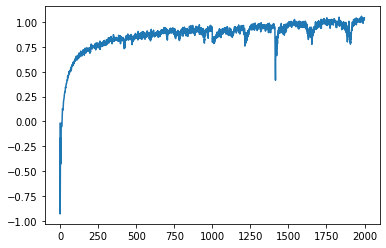

In [37]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)
np.mean(plot_loss[-10:]/np.log(2))